In [1]:
library(ggplot2)
library(ggfortify)
library(tidyverse)
library(stringr)
library(survival)
library(survminer)
library(coxme)
library(Rtsne)
setwd("data")

Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats
Loading required package: bdsmatrix

Attaching package: ‘bdsmatrix’

The following object is masked from ‘package:base’:

    backsolve



# Load CIBERSORT Data

This works similarly to what's done in [TILToolComparisons](TILToolComparisons.ipynb).

In [2]:
tcell.columns = c(
    'T.cells.CD8',
    'T.cells.CD4.naive',
    'T.cells.CD4.memory.resting',
    'T.cells.CD4.memory.activated',
    'T.cells.follicular.helper',
    'T.cells.regulatory..Tregs.',
    'T.cells.gamma.delta'
)

cibersort <-
    read_tsv("cibersort-output.tsv", comment=">") %>%
    as.data.frame %>%
    rename(SampleName = "Sample Name") %>%
    select(-P.value, -Pearson.Correlation, -RMSE)

cibersort_til <-
    cibersort %>%
    column_to_rownames("SampleName") %>%
    select(tcell.columns) %>%
    rowSums %>%
    as.data.frame %>%
    rename(cibersort = ".") %>%
    rownames_to_column("SampleName") %>%
    as.data.frame

Parsed with column specification:
cols(
  .default = col_double(),
  `Sample Name` = col_character(),
  T.cells.gamma.delta = col_integer(),
  Dendritic.cells.resting = col_integer()
)
See spec(...) for full column specifications.


# Load Patient Data

This code is specific to loading data for patients in the bladder cohort. It's a bit messy and complicated, but I tried to make it as readable as possible.

There are IDs for different samples, and it takes some work to map those samples to the original patient IDs.

In [13]:
# 29 patients
genentech_ids <-
    read_csv("genentech_to_msk_id_map.csv") %>%
    rename(PatientId = `Sample ID`) %>%
    mutate(PatientId = str_replace_all(PatientId, "[^0-9]", "")) %>%
    mutate(PatientId = ifelse(PatientId == "2397", "2937", PatientId)) %>%  # genentech mistake!
    as.data.frame

# 29 patients
patient_ids <-
    read_tsv("2850417_Neoantigen_RNA_bams.csv", col_names = c("MGI DNA Name", "BAM Name")) %>%
    rename(SampleName = `BAM Name`) %>%

    # This extracts the part of the BAM Name we want to match.
    # We deal with periods only throughout the pipeline, for simplicity.
    # (Some tools convert _/- automatically, so it's easier to always use the period.)
    mutate(SampleName = str_replace_all(str_extract(SampleName, "(gerald[^\\.]+)"), "-|_", ".")) %>%

    left_join(read_csv("sequencing_manifest.csv"), by = "MGI DNA Name") %>%

    # Patient IDs are numbers here, but are padded strings in other files.
    mutate(PatientId = str_pad(`Individual Name`, 4, pad="0")) %>%
    select(SampleName, PatientId) %>%

    right_join(genentech_ids, by = "PatientId") %>%  # We want all 29 patient IDs.

    as.data.frame

# 24 patients w/ TCR sequencing
tcr_master <-
    read_csv("tcr_master.csv") %>%
    mutate(PatientId = str_replace(`Subject ID`, "-[A-Z]$", "")) %>%
    filter(`Time Point` == "A", `Sample Type` == "Tumor")

# 29 patients in total
clinical_updated <-
    read_csv("clinical_updated.csv", skip = 1) %>%
    rename(PatientId = ID)

# 29 patients with PD-L1 IHC
keep_ihc_sample = function(id, location) {
    !(id %in% c(1022, 1023, 1026, 1184, 1202, 1232)) |
        (id == 1022 & location == "BLADDER") |
        (id == 1023 & location == "BLADDER") |
        (id == 1026 & location == "BLADDER RADICAL CYSTECTOMY") |
        (id == 1184 & location == "LYMPHNODES") |
        (id == 1202 & location == "BLADDER URETUS BILATERAL TUBES") |
        (id == 1232 & location == "BLADDER")
}

tcga_subtypes <-
    read_csv("tcga_subtypes.csv", skip = 1) %>%
    filter(keep_ihc_sample(`Patient Enrolled ID`, Location))

cohort <-
    patient_ids %>%
    left_join(clinical_updated, by = "PatientId") %>%

    left_join(tcr_master, by = "PatientId") %>%
    left_join(tcga_subtypes, by = c(`Genentech Pt ID` = "Patient Enrolled ID")) %>%

    left_join(cibersort_til, by = "SampleName") %>%

    mutate(
        is_deceased = `Alive Status` == "N",
        is_progressed = `Ongoing Responder RECIST 1.1` == "N",
        is_progressed_or_deceased = is_deceased | is_progressed) %>%

    select(
        SampleName,
        PatientId,
        GenentechPatientId = `Genentech Pt ID`,
        Time = `Time Point`,
        TIL = `T-cell fraction`,
        IC.PDL1 = `PD-L1`,
        PDL1 = `Raw ICp`,
        mPFS = `PFS (mRECIST 1.1) in days`,
        PFS = `PFS (RECIST 1.1) in days`,
        OS = `OS in days`,
        is_deceased,
        is_progressed,
        is_progressed_or_deceased,
        cibersort) %>%
    mutate(DCB = as.integer(PFS) > 182) %>%
    as.data.frame

# 29 patients in total.
stopifnot(nrow(cohort) == 29)

# 24 patients w/ TCRseq data.
stopifnot(nrow(
    cohort %>%
        filter(!is.na(TIL)))
    == 24)

# 26 patients w/ RNAseq data.
stopifnot(nrow(
    cohort %>%
        filter(!is.na(cibersort)))
    == 26)

head(cohort)

Parsed with column specification:
cols(
  `Genentech Pt ID` = col_integer(),
  `Sample ID` = col_character()
)
Parsed with column specification:
cols(
  `MGI DNA Name` = col_character(),
  `BAM Name` = col_character()
)
Parsed with column specification:
cols(
  `Individual Name` = col_integer(),
  `Sample Name` = col_character(),
  `DNA Type` = col_character(),
  `Tissue Name` = col_character(),
  `Common Name` = col_character(),
  `MGI DNA Name` = col_character(),
  `Sequence Plan` = col_character(),
  Status = col_character()
)
Parsed with column specification:
cols(
  `Subject ID` = col_character(),
  `Sample ID` = col_character(),
  Product = col_character(),
  `Sample Type` = col_character(),
  `Time Point` = col_character(),
  `Clinical Response` = col_character(),
  `Cell count` = col_double(),
  `Productive TCR Templates(cnt)` = col_double(),
  `T-cell fraction` = col_double(),
  Clonality = col_double(),
  Diversity = col_double(),
  `Productive Unique TCRs (cnt)` = col_intege

SampleName,PatientId,GenentechPatientId,Time,TIL,IC.PDL1,PDL1,mPFS,PFS,OS,is_deceased,is_progressed,is_progressed_or_deceased,cibersort,DCB
gerald.H5NKVBBXX.5.ATTACTCG.TATAGCCT,1233,1023,A,0.2171,IC2,5,398,398,724,FALSE,TRUE,TRUE,0.3111903,TRUE
gerald.H5NKVBBXX.7.ATTCAGAA.TATAGCCT,2278,1064,A,0.0486,IC1,1,655,655,702,FALSE,FALSE,FALSE,0.2688517,TRUE
gerald.H5NKVBBXX.5.TCCGGAGA.ATAGAGGC,5122,1074,A,0.0548,IC2,5,565,565,700,FALSE,FALSE,FALSE,0.4208135,TRUE
gerald.H5NKVBBXX.4.CTGAAGCT.ATAGAGGC,6800,1162,NA,NA,IC1,1,650,650,651,FALSE,FALSE,FALSE,0.2074370,TRUE
gerald.H5NKVBBXX.7.GAATTCGT.TATAGCCT,2389,1182,A,0.3340,IC2,5,646,646,651,FALSE,FALSE,FALSE,0.3738789,TRUE
gerald.H5NKVBBXX.7.TCCGGAGA.CCTATCCT,2131,1228,A,0.2009,IC2,5,560,560,630,FALSE,FALSE,FALSE,0.3538645,TRUE


# Although Adaptive's TCF is correlated with DCB, CIBERSORT's TCF is not.

This is unrelated to the PD-L1 analysis, but it was to check the quality of CIBERSORT's results, beyond its reported p-values. The bladder cohort paper reports that Adaptive's TCF (referred to as TIL in the paper) is correlated with durable clinical benefit, CIBERSORT's TCF is not. We replicate the former result below and add the latter.

Warning message:
“Removed 5 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 5 rows containing missing values (geom_point).”Warning message:
“Removed 5 rows containing missing values (geom_point).”


	Wilcoxon rank sum test

data:  TIL by DCB
W = 31, p-value = 0.04482
alternative hypothesis: true location shift is not equal to 0


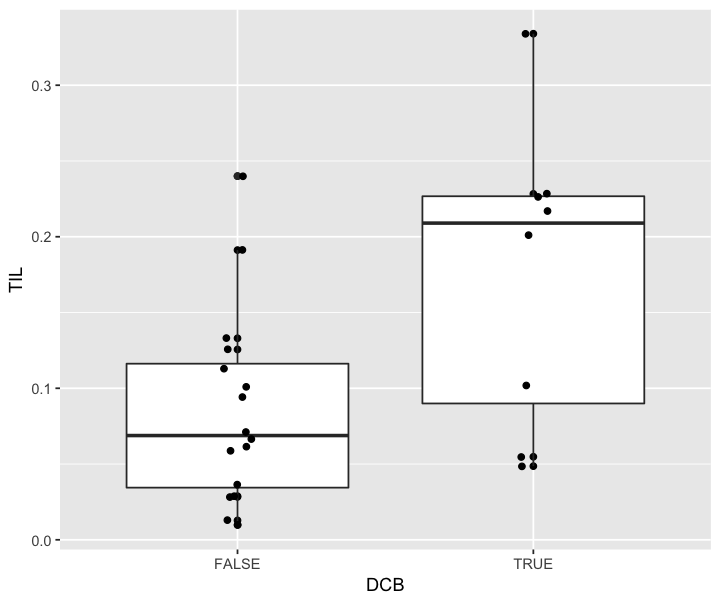

In [14]:
options(repr.plot.width = 6, repr.plot.height = 5)
ggplot(cohort, aes(DCB, TIL)) + geom_point() + geom_boxplot() + geom_jitter(width = 0.05)
wilcox.test(TIL ~ DCB, data = cohort)

Warning message:
“Removed 3 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 3 rows containing missing values (geom_point).”Warning message:
“Removed 3 rows containing missing values (geom_point).”


	Wilcoxon rank sum test

data:  cibersort by DCB
W = 67, p-value = 0.634
alternative hypothesis: true location shift is not equal to 0


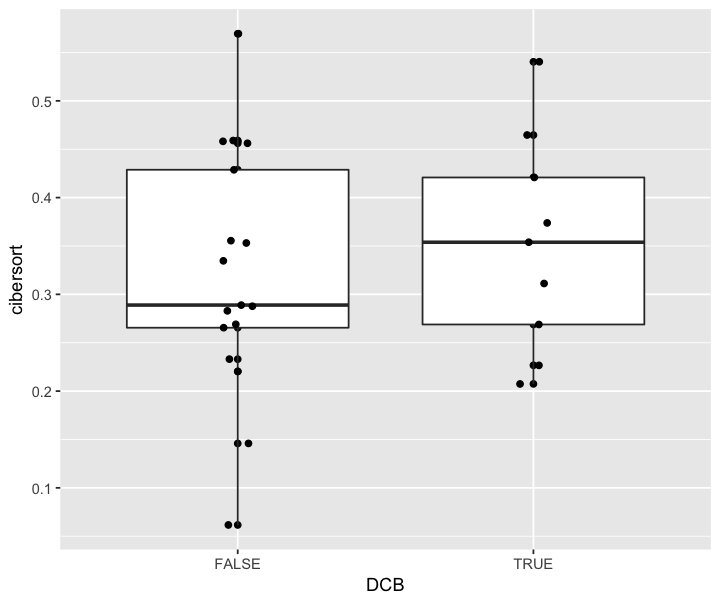

In [15]:
ggplot(cohort, aes(DCB, cibersort)) + geom_point() + geom_boxplot() + geom_jitter(width = 0.05)
wilcox.test(cibersort ~ DCB, data = cohort)

# Data Visualization

Below I visualize the bladder cohort data in different ways. Doing this serves two purposes:

1. To look for patterns and outliers; to interrogate the questions I already have; to discover new ones.
2. To practice ggplot2 and R :)

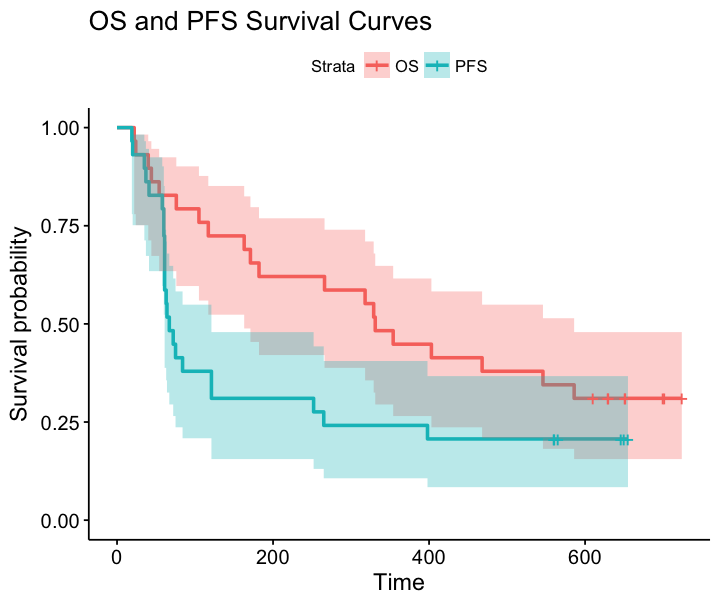

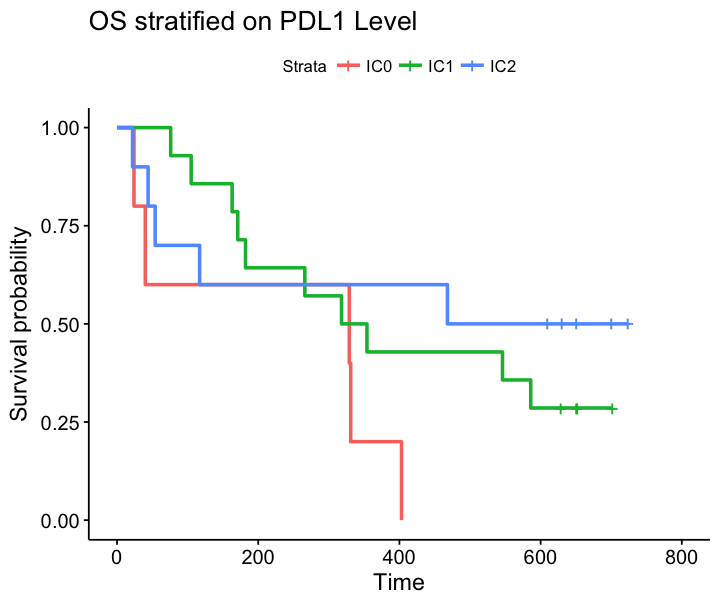

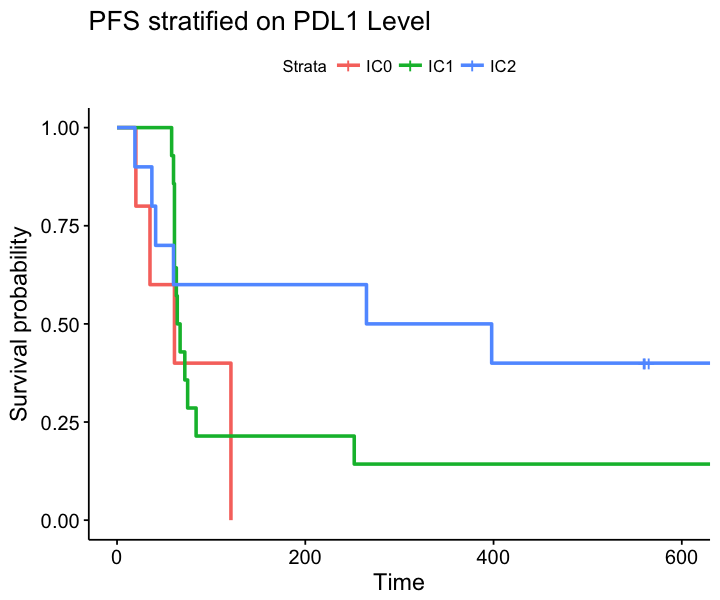

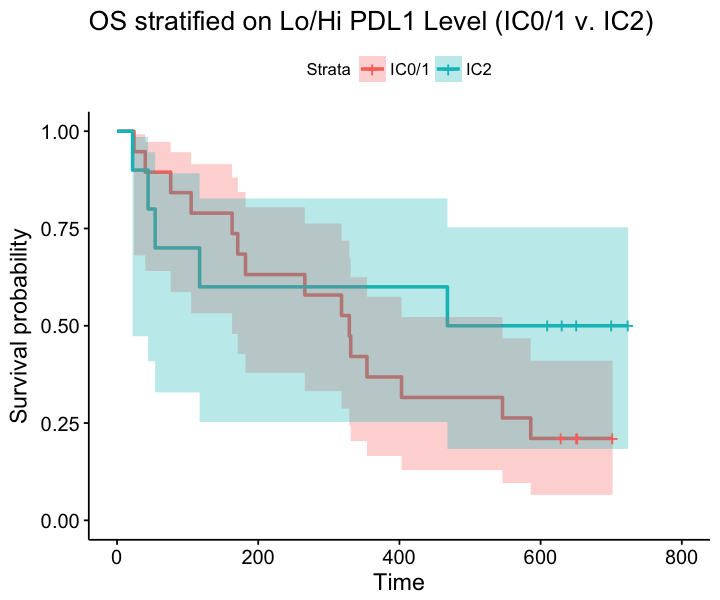

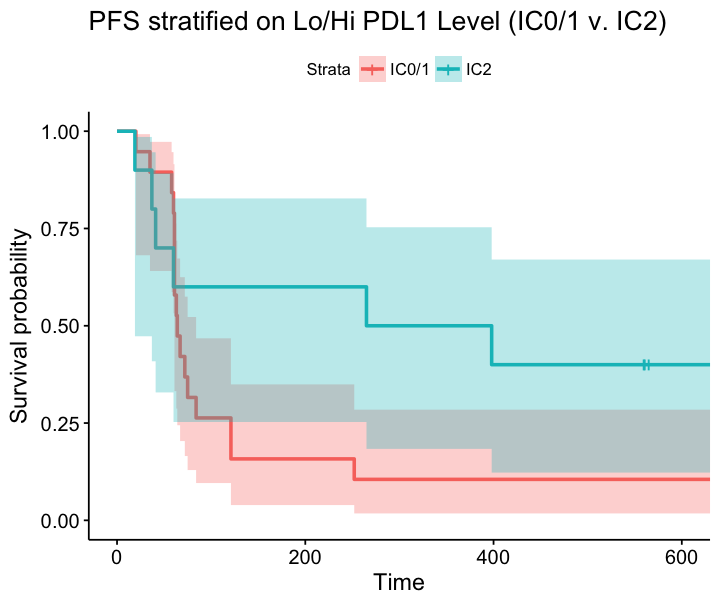

In [18]:
surv.os <- with(cohort, Surv(OS, is_deceased))
surv.pfs <- with(cohort, Surv(PFS, is_progressed_or_deceased))

km.os.as.one <- survfit(surv.os ~ 1, data = cohort, conf.type = "log-log")
km.os.by.pdl1 <- survfit(surv.os ~ IC.PDL1, data = cohort, conf.type = "log-log")
km.os.by.pdl1.lowhigh <- survfit(surv.os ~ (IC.PDL1 == "IC2"), data = cohort, conf.type = "log-log")

km.pfs.as.one <- survfit(surv.pfs ~ 1, data = cohort, conf.type = "log-log")
km.pfs.by.pdl1 <- survfit(surv.pfs ~ IC.PDL1, data = cohort, conf.type = "log-log")
km.pfs.by.pdl1.lowhigh <- survfit(surv.pfs ~ (IC.PDL1 == "IC2"), data = cohort, conf.type = "log-log")

ggsurvplot_combine(list(km.os.as.one, km.pfs.as.one), conf.int = TRUE, legend.labs = c("OS", "PFS")) + ggtitle("OS and PFS Survival Curves")
ggsurvplot(km.os.by.pdl1, legend.labs = c("IC0", "IC1", "IC2")) + ggtitle("OS stratified on PDL1 Level")
ggsurvplot(km.pfs.by.pdl1, legend.labs = c("IC0", "IC1", "IC2")) + ggtitle("PFS stratified on PDL1 Level")
ggsurvplot(km.os.by.pdl1.lowhigh, conf.int = TRUE, legend.labs = c("IC0/1", "IC2")) + ggtitle("OS stratified on Lo/Hi PDL1 Level (IC0/1 v. IC2)")
ggsurvplot(km.pfs.by.pdl1.lowhigh, conf.int = TRUE, legend.labs = c("IC0/1", "IC2")) + ggtitle("PFS stratified on Lo/Hi PDL1 Level (IC0/1 v. IC2)")

## Visualize CIBERSORT Results with T-SNE

In [987]:
tsne_model <- Rtsne(cibersort, perplexity = 8, max_iter = 1500)
print(tsne_model$itercosts)
reduced <- tsne_model$Y
colnames(reduced) <- c("ReducedX", "ReducedY")
cohort_cibersort_reduced <- cbind(cibersort, reduced) %>% left_join(cohort, by = "SampleName")
head(cohort_cibersort_reduced)

 [1] 54.3010540 55.9690677 53.0333924 52.2286226 58.5900594  1.3272810
 [7]  1.0144542  0.7895811  0.6412691  0.5081067  0.3185871  0.2564500
[13]  0.2442566  0.2242056  0.2162593  0.2118917  0.1729014  0.1715973
[19]  0.1760541  0.1924206  0.1790022  0.1729932  0.1721433  0.1737512
[25]  0.1819849  0.1758927  0.1797616  0.1677516  0.1779300  0.1650566


SampleName,B.cells.naive,B.cells.memory,Plasma.cells,T.cells.CD8,T.cells.CD4.naive,T.cells.CD4.memory.resting,T.cells.CD4.memory.activated,T.cells.follicular.helper,T.cells.regulatory..Tregs.,⋯,IC.PDL1,PDL1,mPFS,PFS,OS,is_deceased,is_progressed,is_progressed_or_deceased,cibersort,DCB
gerald.H5NKVBBXX.4.CGGCTATG.TATAGCCT,0,0.009771911,0.02224297,0.0157126834,0.000000000,0.38175208,0,0.06156646,0.000000000,⋯,IC1,1,64,64,182,TRUE,TRUE,TRUE,0.4590312,FALSE
gerald.H5NKVBBXX.4.CTGAAGCT.ATAGAGGC,0,0.148455047,0.04940588,0.0515763008,0.000000000,0.09240452,0,0.06345619,0.000000000,⋯,IC1,1,650,650,651,FALSE,FALSE,FALSE,0.2074370,TRUE
gerald.H5NKVBBXX.4.TAATGCGC.ATAGAGGC,0,0.035043026,0.02598776,0.0863864400,0.003953619,0.00000000,0,0.12493367,0.053739400,⋯,IC2,15,60,60,117,TRUE,TRUE,TRUE,0.2690131,FALSE
gerald.H5NKVBBXX.4.TAATGCGC.TATAGCCT,0,0.203036133,0.00000000,0.0003120516,0.155452390,0.00000000,0,0.07119948,0.060703129,⋯,IC2,8,37,37,44,TRUE,TRUE,TRUE,0.2876670,FALSE
gerald.H5NKVBBXX.4.TCTCGCGC.ATAGAGGC,0,0.128308734,0.00000000,0.0863717301,0.100288831,0.05715928,0,0.00000000,0.184973878,⋯,IC0,0,178,121,331,TRUE,TRUE,TRUE,0.4287937,FALSE
gerald.H5NKVBBXX.5.ATTACTCG.ATAGAGGC,0,0.149078929,0.00000000,0.0000000000,0.076685875,0.33076509,0,0.04871759,0.008477253,⋯,IC2,5,561,561,610,FALSE,FALSE,FALSE,0.4646458,TRUE


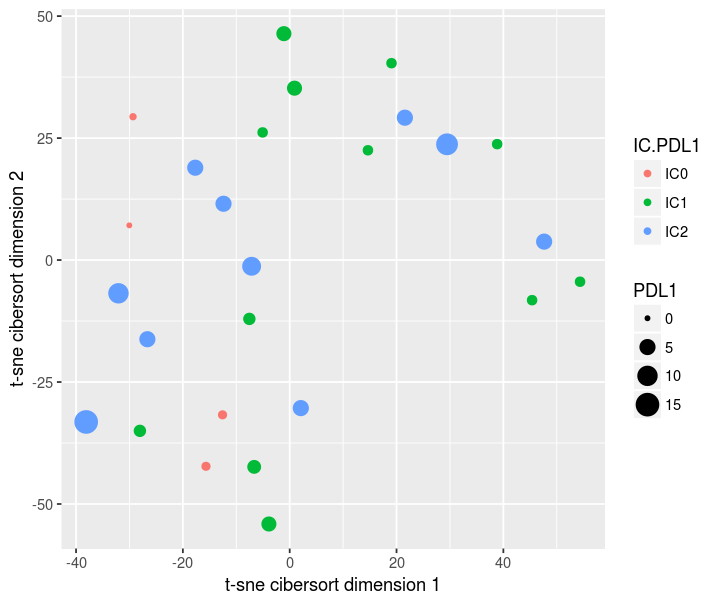

In [988]:
ggplot(
    cohort_cibersort_reduced,
    aes(ReducedX, ReducedY, size = PDL1, color = IC.PDL1)) +
geom_point() +
xlab("t-sne cibersort dimension 1") +
ylab("t-sne cibersort dimension 2")

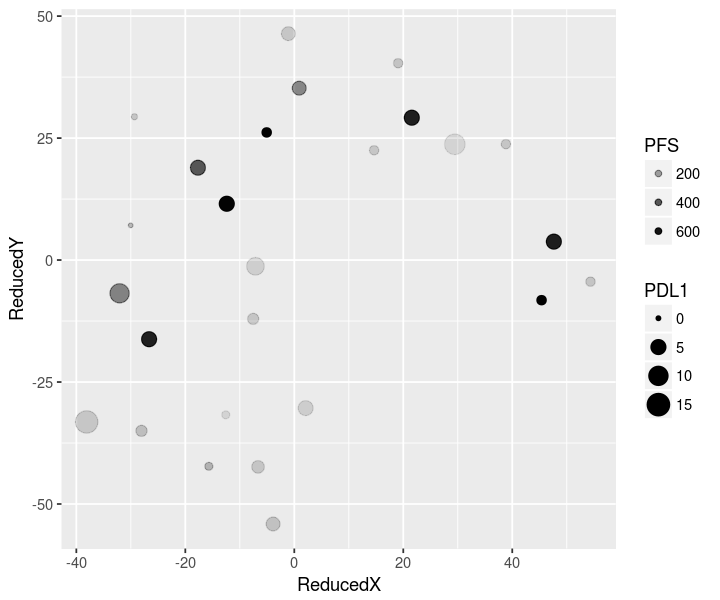

In [989]:
ggplot(
    cohort_cibersort_reduced,
    aes(ReducedX, ReducedY, size = PDL1, alpha = PFS)) +
geom_point()

Adaptive's TCF seems much more qualitatively "organized", compared to CIBERSORT's TCF, in the cibersort data below.

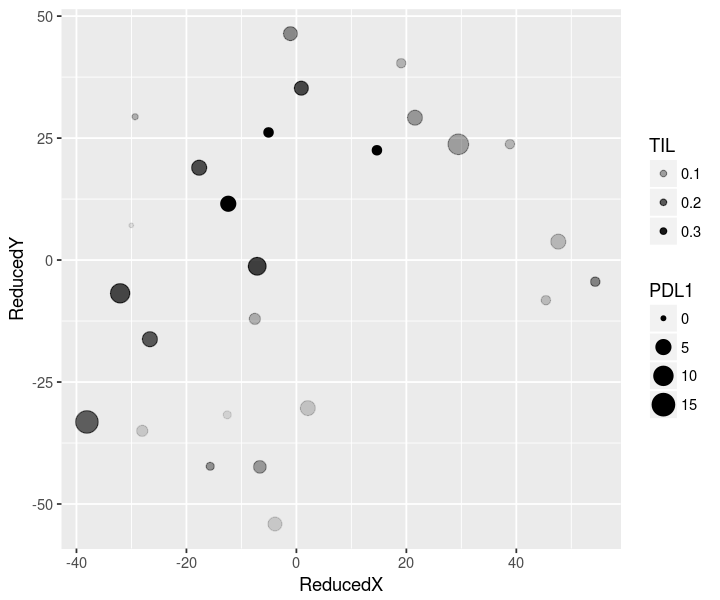

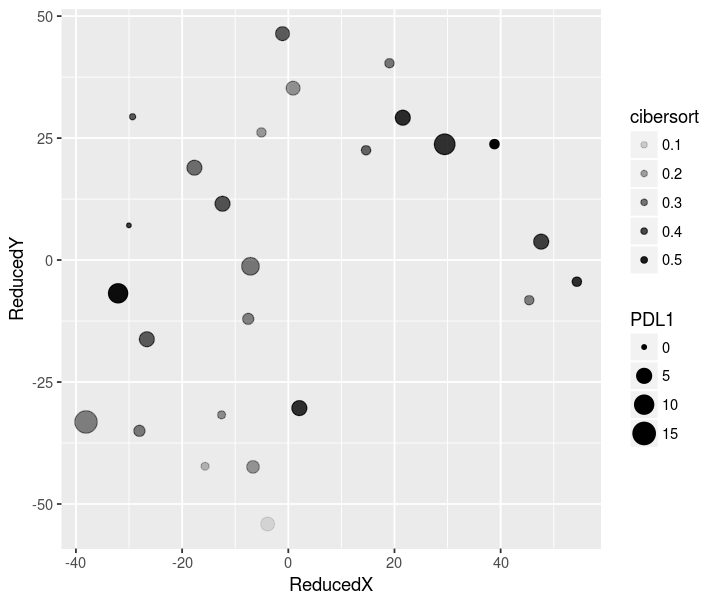

In [990]:
ggplot(
    cohort_cibersort_reduced,
    aes(ReducedX, ReducedY, size = PDL1, alpha = TIL)) +
geom_point()

ggplot(
    cohort_cibersort_reduced,
    aes(ReducedX, ReducedY, size = PDL1, alpha = cibersort)) +
geom_point()

Patients in the IC2 PDL1 bucket seem to have higher TIL in general. Does PDL1 level encourage infiltration of T-cells? (This seems unlikely, but possible.)

Does high PDL1 or TIL imply a generally higher immune system?

Warning message:
“Removed 2 rows containing missing values (geom_point).”

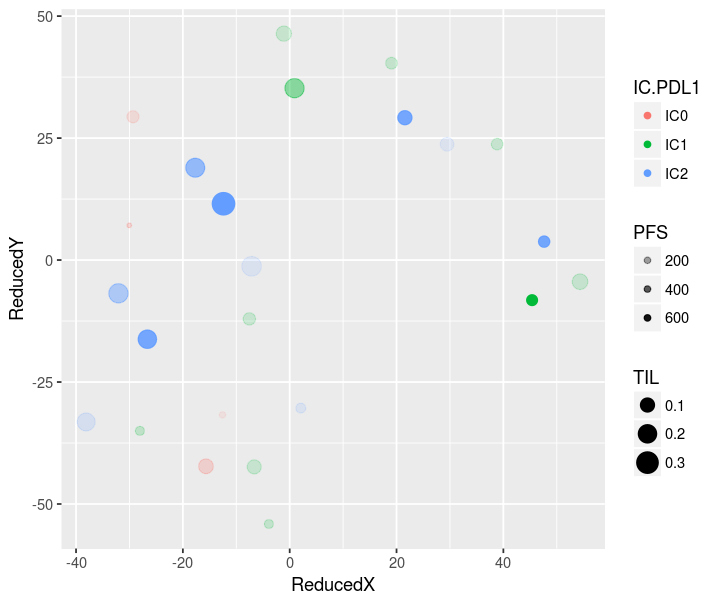

In [991]:
ggplot(
    cohort_cibersort_reduced,
    aes(ReducedX, ReducedY, color = IC.PDL1, size = TIL, alpha = PFS)) +
geom_point()

# Clustering

We cluster CIBERSORT data into 4 clusters (I had tried 1-10, and 4 looked best), then visualize the clusters through data reduction using t-sne.

Cluster #4 seems particularly separate from the others. I wonder what makes it different. (Note: I never explored this in much depth.)

[1] "k = 4: 2 iterations to convergence."
 [1] 54.0876820 59.8579986 69.0028998 55.5615473 56.6939907  1.7375174
 [7]  1.2960032  0.8693642  0.5877434  0.3801612  0.3015716  0.2664177
[13]  0.2385322  0.2309747  0.2162617  0.2457660  0.2428019  0.2521784
[19]  0.2356992  0.2395785  0.2376432  0.2352323  0.2351054  0.2401535
[25]  0.2433960  0.2269412  0.2228679  0.2207440  0.2225559  0.2286056


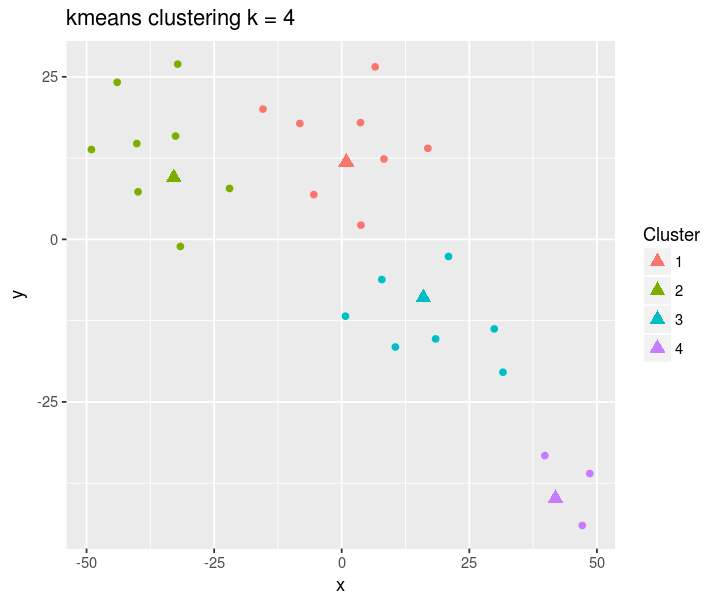

In [1091]:
nclusters <- 4

# 1. Cluster cibersort data for `k = nclusters`.
cluster_model <- kmeans(cibersort %>% select(-SampleName), nclusters, iter.max = 1000)
print(paste0("k = ", nclusters, ": ", cluster_model$iter, " iterations to convergence."))
centroids <- cluster_model$centers

# This adds the cluster centroids as cibersort rows.
cibersort_and_centroids <- rbind(
    cibersort %>% column_to_rownames("SampleName"), centroids)

# 2. Run TSNE on cibersort data and cluster centroids for visualization.
tsne_model <- Rtsne(cibersort_and_centroids, perplexity = 9, max_iter = 1500)
print(tsne_model$itercosts)
reduced <- tsne_model$Y
colnames(reduced) <- c("x", "y")

# 3. Build dataframe with for cibersort data and centroids.
reduced_cibersort <-
    cluster_model$cluster %>%
    as.data.frame %>%
    rename("Cluster" = ".") %>%
    mutate(Cluster = as.factor(Cluster)) %>%
    cbind(head(reduced, n = 26))

reduced_centroids <-
    tail(reduced, n = nclusters) %>%
    cbind(data.frame(Cluster = as.factor(1:nclusters)))

# 4. Plot.
print(
    ggplot() +
    geom_point(data = reduced_cibersort, mapping = aes(x, y, color = Cluster)) +
    geom_point(data = reduced_centroids, mapping = aes(x, y, color = Cluster), shape = 17, size = 3) +
    ggtitle(paste0("kmeans clustering k = ", nclusters))
)

PDL1 levels seem generally low in cluster 4, but it's hard to make any definitive conclusions since there are so few patients in that cluster.

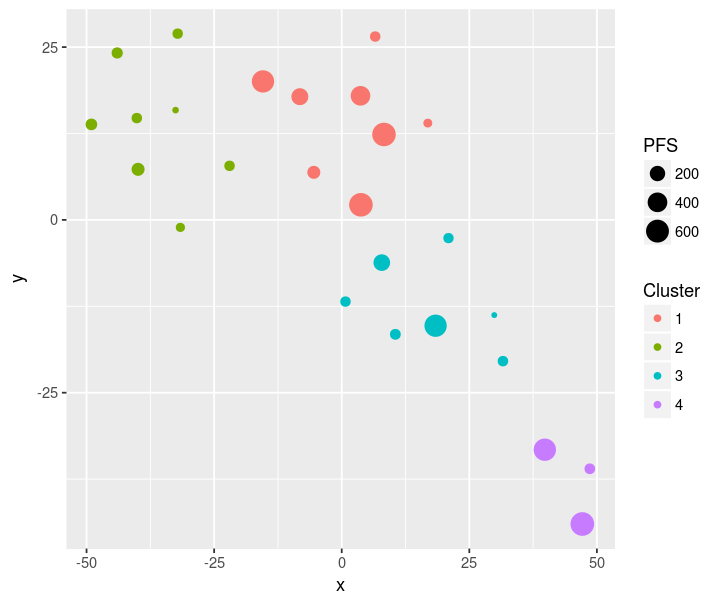

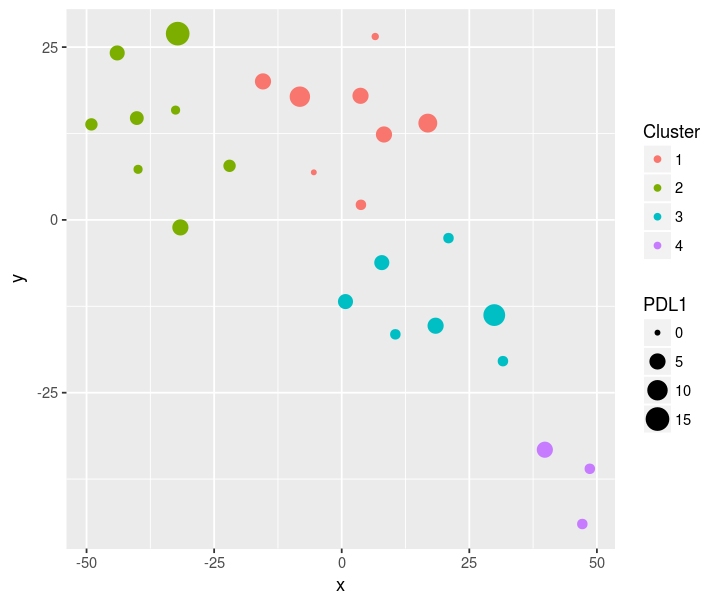

In [1117]:
cohort_extended <-
    reduced_cibersort %>%
    cbind(cibersort) %>%
    left_join(cohort, by = "SampleName")

ggplot(cohort_extended, aes(x, y, color = Cluster, size = PFS)) +
    geom_point()

ggplot(cohort_extended, aes(x, y, color = Cluster, size = PDL1)) +
    geom_point()

# Basic Survival Analyses on PDL1

Why is $\exp(\text{coef}) \geq 1$ for PDL1?

In the mixed-effect model, split on IC PDL1 bin, the intercept decreases with increasing PDL1 bin. The fixed effect coefficient for PDL1, however, is still greater than 1.

The latter model *seems* to imply that more PDL1 has a greater (negative) effect on hazard the higher PDL1 levels are in the first place. This is likely because of the varying scales of each bucket (IC0 PDL1 values are low, so the intercept has to compensate by becoming larger). We try centering within each bucket next.

In [1276]:
model0 <- coxph(Surv(OS, is_deceased) ~ PDL1, data = cohort)
model1 <- coxph(Surv(PFS, is_progressed_or_deceased) ~ PDL1, data = cohort)
summary(model0)
summary(model1)n

Call:
coxph(formula = Surv(OS, is_deceased) ~ PDL1, data = cohort)

  n= 29, number of events= 20 

        coef exp(coef) se(coef)     z Pr(>|z|)
PDL1 0.04136   1.04223  0.07342 0.563    0.573

     exp(coef) exp(-coef) lower .95 upper .95
PDL1     1.042     0.9595    0.9025     1.204

Concordance= 0.468  (se = 0.07 )
Rsquare= 0.01   (max possible= 0.982 )
Likelihood ratio test= 0.3  on 1 df,   p=0.5838
Wald test            = 0.32  on 1 df,   p=0.5732
Score (logrank) test = 0.32  on 1 df,   p=0.573


Call:
coxph(formula = Surv(PFS, is_progressed_or_deceased) ~ PDL1, 
    data = cohort)

  n= 29, number of events= 23 

        coef exp(coef) se(coef)     z Pr(>|z|)
PDL1 0.02081   1.02102  0.07154 0.291    0.771

     exp(coef) exp(-coef) lower .95 upper .95
PDL1     1.021     0.9794    0.8874     1.175

Concordance= 0.457  (se = 0.069 )
Rsquare= 0.003   (max possible= 0.988 )
Likelihood ratio test= 0.08  on 1 df,   p=0.7739
Wald test            = 0.08  on 1 df,   p=0.7712
Score (logrank) test = 0.08  on 1 df,   p=0.7712


In [1287]:
model0 <- coxme(Surv(OS, is_deceased) ~ PDL1 + (1|IC.PDL1), data = cohort)
model1 <- coxme(Surv(PFS, is_progressed_or_deceased) ~ PDL1 + (1|IC.PDL1), data = cohort)
exp(ranef(model0)[[1]])
summary(model0)
exp(ranef(model1)[[1]])
summary(model1)

IC0       IC1       IC2 
3.2628468 1.0063016 0.3045616

Cox mixed-effects model fit by maximum likelihood
  Data: cohort
  events, n = 20, 29
  Iterations= 5 29 
                    NULL Integrated    Fitted
Log-likelihood -58.45521  -57.03739 -53.82037

                  Chisq   df        p   AIC   BIC
Integrated loglik  2.84 2.00 0.242240 -1.16 -3.16
 Penalized loglik  9.27 2.65 0.018951  3.97  1.34

Model:  Surv(OS, is_deceased) ~ PDL1 + (1 | IC.PDL1) 
Fixed coefficients
          coef exp(coef)   se(coef)    z     p
PDL1 0.2165223  1.241751 0.09094407 2.38 0.017

Random effects
 Group   Variable  Std Dev  Variance
 IC.PDL1 Intercept 1.244059 1.547683


IC0       IC1       IC2 
3.0420261 1.2642444 0.2600196

Cox mixed-effects model fit by maximum likelihood
  Data: cohort
  events, n = 23, 29
  Iterations= 5 24 
                    NULL Integrated   Fitted
Log-likelihood -64.67779  -62.96366 -59.5734

                  Chisq   df        p   AIC   BIC
Integrated loglik  3.43 2.00 0.180120 -0.57 -2.84
 Penalized loglik 10.21 2.68 0.012569  4.85  1.80

Model:  Surv(PFS, is_progressed_or_deceased) ~ PDL1 + (1 | IC.PDL1) 
Fixed coefficients
          coef exp(coef)   se(coef)   z     p
PDL1 0.2291868  1.257577 0.09164999 2.5 0.012

Random effects
 Group   Variable  Std Dev  Variance
 IC.PDL1 Intercept 1.295681 1.678788


After centering within each bucket, the random effects are much more reasonable.

In [1372]:
model <-
    cohort %>%
    group_by(IC.PDL1) %>%
    mutate(PDL1 = PDL1 - mean(PDL1)) %>%  # Center w/i each group
    coxme(Surv(OS, is_deceased) ~ PDL1 + (1|IC.PDL1), data = .)

summary(model)
exp(ranef(model)[[1]])

Cox mixed-effects model fit by maximum likelihood
  Data: .
  events, n = 20, 29
  Iterations= 2 12 
                    NULL Integrated    Fitted
Log-likelihood -58.45521  -55.13103 -55.02115

                  Chisq  df        p  AIC  BIC
Integrated loglik  6.65 2.0 0.036002 2.65 0.66
 Penalized loglik  6.87 1.1 0.010418 4.66 3.56

Model:  Surv(OS, is_deceased) ~ PDL1 + (1 | IC.PDL1) 
Fixed coefficients
          coef exp(coef)   se(coef)    z      p
PDL1 0.2506825  1.284902 0.08988844 2.79 0.0053

Random effects
 Group   Variable  Std Dev    Variance  
 IC.PDL1 Intercept 0.10010698 0.01002141


IC0       IC1       IC2 
1.0268854 0.9918002 0.9818695

# How do TIL and PDL1 levels interact, if at all?

It seems like an increase in TIL or PDL1 effectively increments the other coefficient by $1.402$. This is confusing, as I would have guessed that both TIL and PDL1 positively correspond with survival. Under these assumptions, the interaction coefficient would be non-positive.

The next set of models incorporates cluster number for each patient. None of the cluster coefficients are significant (or very close to), but the model scoring metrics are all higher.

In [1174]:
model0 <- coxph(Surv(OS, is_deceased) ~ TIL * PDL1, data = cohort)
model1 <- coxph(Surv(PFS, is_progressed_or_deceased) ~ TIL * PDL1, data = cohort)
summary(model0)
summary(model1)

Call:
coxph(formula = Surv(OS, is_deceased) ~ TIL * PDL1, data = cohort)

  n= 24, number of events= 16 
   (5 observations deleted due to missingness)

               coef  exp(coef)   se(coef)      z Pr(>|z|)  
TIL      -1.472e+01  4.061e-07  7.038e+00 -2.091   0.0365 *
PDL1     -2.712e-02  9.732e-01  1.979e-01 -0.137   0.8910  
TIL:PDL1  1.402e+00  4.065e+00  1.205e+00  1.164   0.2444  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

         exp(coef) exp(-coef) lower .95 upper .95
TIL      4.061e-07  2.462e+06 4.152e-13    0.3973
PDL1     9.732e-01  1.027e+00 6.603e-01    1.4345
TIL:PDL1 4.065e+00  2.460e-01 3.832e-01   43.1219

Concordance= 0.685  (se = 0.08 )
Rsquare= 0.241   (max possible= 0.975 )
Likelihood ratio test= 6.63  on 3 df,   p=0.08484
Wald test            = 5.86  on 3 df,   p=0.1184
Score (logrank) test = 6.42  on 3 df,   p=0.09269


Call:
coxph(formula = Surv(PFS, is_progressed_or_deceased) ~ TIL * 
    PDL1, data = cohort)

  n= 24, number of events= 19 
   (5 observations deleted due to missingness)

               coef  exp(coef)   se(coef)      z Pr(>|z|)
TIL      -8.1500158  0.0002887  5.7564833 -1.416    0.157
PDL1      0.0363608  1.0370299  0.1803959  0.202    0.840
TIL:PDL1  0.5592004  1.7492731  1.0782815  0.519    0.604

         exp(coef) exp(-coef) lower .95 upper .95
TIL      0.0002887  3463.4336 3.636e-09    22.931
PDL1     1.0370299     0.9643 7.282e-01     1.477
TIL:PDL1 1.7492731     0.5717 2.114e-01    14.477

Concordance= 0.628  (se = 0.08 )
Rsquare= 0.138   (max possible= 0.984 )
Likelihood ratio test= 3.56  on 3 df,   p=0.313
Wald test            = 3.21  on 3 df,   p=0.3607
Score (logrank) test = 3.33  on 3 df,   p=0.3434


In [1352]:
model0 <- coxph(Surv(OS, is_deceased) ~ TIL * PDL1 + Cluster, data = cohort_extended)
model1 <- coxph(Surv(PFS, is_progressed_or_deceased) ~ TIL * PDL1 + Cluster, data = cohort_extended)
summary(model0)
summary(model1)

Call:
coxph(formula = Surv(OS, is_deceased) ~ TIL * PDL1 + Cluster, 
    data = cohort_extended)

  n= 24, number of events= 16 
   (2 observations deleted due to missingness)

               coef  exp(coef)   se(coef)      z Pr(>|z|)  
TIL      -1.396e+01  8.688e-07  7.222e+00 -1.932   0.0533 .
PDL1     -9.042e-02  9.135e-01  2.748e-01 -0.329   0.7421  
Cluster2  6.387e-01  1.894e+00  8.741e-01  0.731   0.4650  
Cluster3 -6.118e-02  9.407e-01  8.893e-01 -0.069   0.9451  
Cluster4 -9.810e-01  3.749e-01  1.270e+00 -0.773   0.4397  
TIL:PDL1  1.568e+00  4.797e+00  1.555e+00  1.009   0.3132  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

         exp(coef) exp(-coef) lower .95 upper .95
TIL      8.688e-07  1.151e+06 6.185e-13     1.220
PDL1     9.135e-01  1.095e+00 5.331e-01     1.565
Cluster2 1.894e+00  5.280e-01 3.414e-01    10.506
Cluster3 9.407e-01  1.063e+00 1.646e-01     5.375
Cluster4 3.749e-01  2.667e+00 3.113e-02     4.515
TIL:PDL1 4.797e+00  2.085e-01 2.278

Call:
coxph(formula = Surv(PFS, is_progressed_or_deceased) ~ TIL * 
    PDL1 + Cluster, data = cohort_extended)

  n= 24, number of events= 19 
   (2 observations deleted due to missingness)

               coef  exp(coef)   se(coef)      z Pr(>|z|)
TIL      -9.602e+00  6.759e-05  6.316e+00 -1.520    0.128
PDL1     -6.158e-02  9.403e-01  2.516e-01 -0.245    0.807
Cluster2  1.066e+00  2.903e+00  8.034e-01  1.327    0.185
Cluster3  7.040e-01  2.022e+00  8.112e-01  0.868    0.385
Cluster4 -1.204e+00  3.001e-01  1.239e+00 -0.972    0.331
TIL:PDL1  1.064e+00  2.899e+00  1.455e+00  0.732    0.464

         exp(coef) exp(-coef) lower .95 upper .95
TIL      6.759e-05  1.479e+04 2.843e-10    16.071
PDL1     9.403e-01  1.064e+00 5.743e-01     1.540
Cluster2 2.903e+00  3.445e-01 6.012e-01    14.017
Cluster3 2.022e+00  4.946e-01 4.123e-01     9.914
Cluster4 3.001e-01  3.332e+00 2.648e-02     3.401
TIL:PDL1 2.899e+00  3.449e-01 1.674e-01    50.203

Concordance= 0.733  (se = 0.08 )
Rsquare= 0.361   

,TIL,PDL1,Cluster2,Cluster3,Cluster4,TIL:PDL1
19,0.0005058607,6.8750202,-0.6244274,0.7733687,-0.01758673,0.39194443
20,-0.0806671307,-4.2579139,0.3422336,-0.1853402,-0.01852570,-0.70872917
37,0.1372848055,2.7539386,-0.6185311,-0.2065884,-0.02064958,1.12361875
41,-0.0633936699,-0.1854495,0.3678556,-0.2111353,-0.02110406,-0.59015134
60,0.0906603999,10.3369593,0.4179233,-0.2348748,-0.02464944,2.15283639
60,0.0250603999,-0.6630407,-0.5820767,0.7651252,-0.02464944,-0.21276361
61,-0.0163748343,-2.7259208,-0.5115621,-0.2482818,-0.03452293,-0.32502073
61,-0.0119748343,-0.8259208,0.4884379,-0.2482818,-0.03452293,-0.18968073
61,0.0179251657,0.1740792,0.4884379,-0.2482818,-0.03452293,-0.02898073
61,-0.0241748343,-1.8259208,-0.5115621,0.7517182,-0.03452293,-0.27288073


             rho  chisq      p
TIL      -0.1730 0.6426 0.4228
PDL1     -0.3809 5.9202 0.0150
Cluster2  0.3025 2.6278 0.1050
Cluster3  0.1277 0.3651 0.5457
Cluster4  0.0595 0.0932 0.7601
TIL:PDL1  0.3353 3.9377 0.0472
GLOBAL        NA 8.5989 0.1974

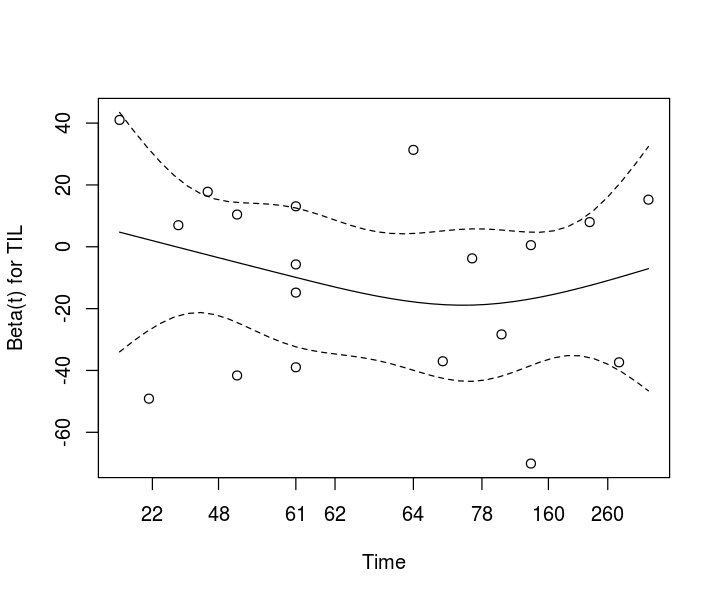

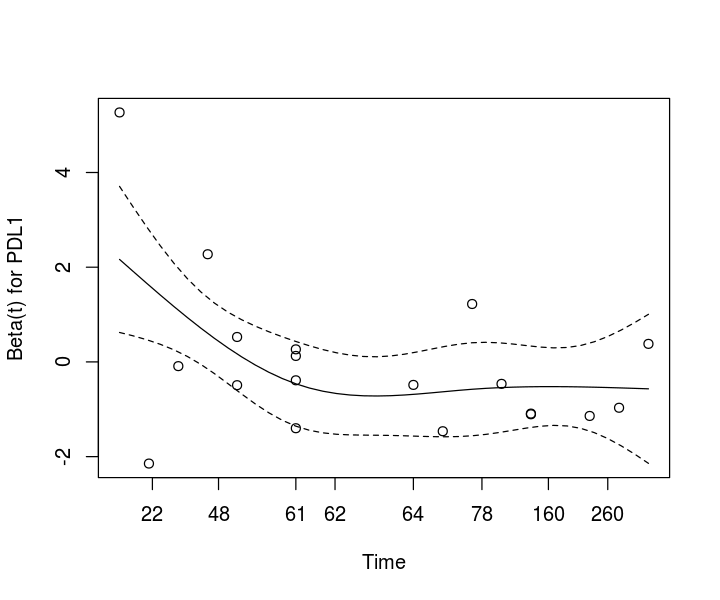

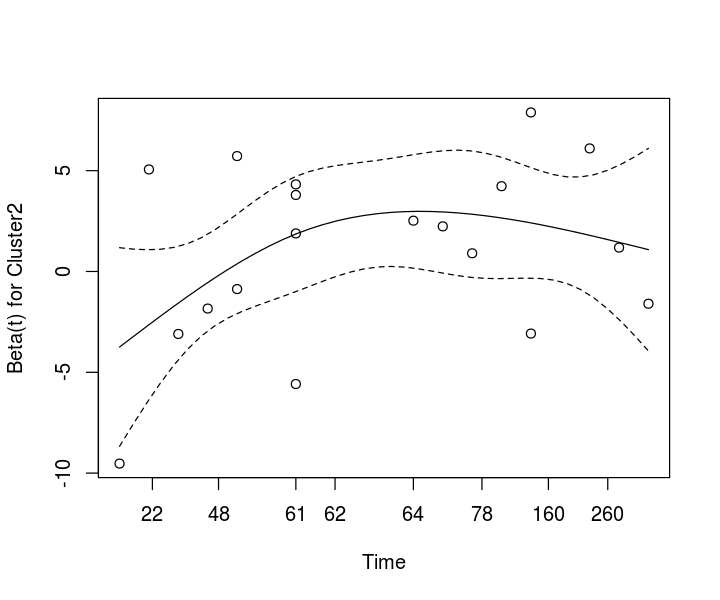

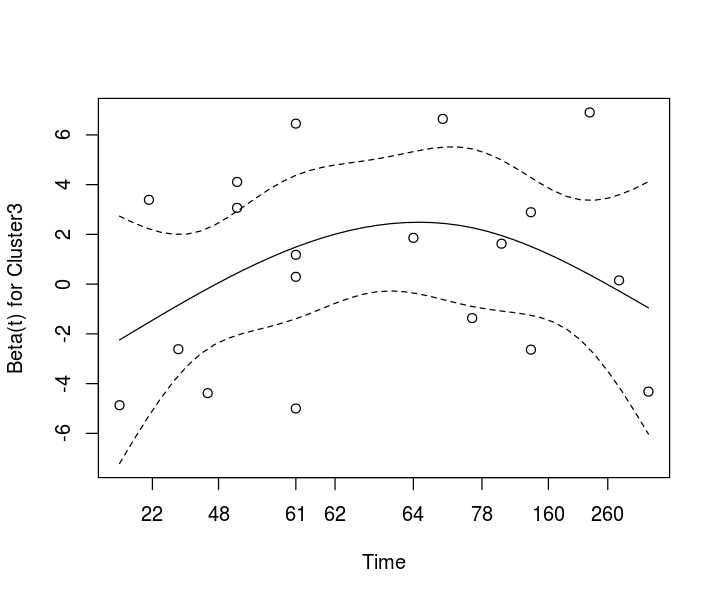

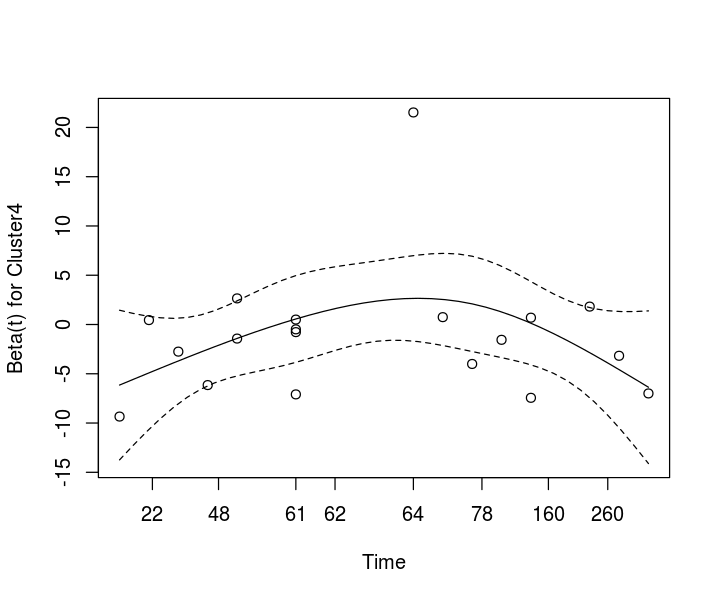

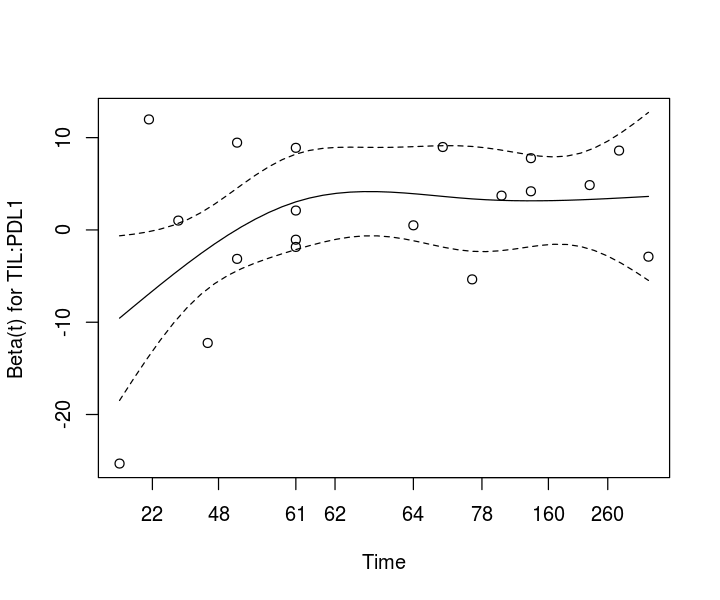

In [1376]:
residuals(model1, type="schoenfeld")
cox.zph(model1)
plot(cox.zph(model1))

# Do minor differences in PDL1 levels affect outcome when $\text{PDL1} \leq 1$?

PDL1 levels are more fine-grained when $\text{PDL1} \leq 1$, so I wonder if those small differences make a large difference in survival, or if knowing that $\text{PDL1} \leq 1$ is enough?

It seems like the PDL1 coefficient finally makes sense for already small values of PDL1, though $p = 0.6$. I'm not sure if this is statistically sound, but I ran this model on 10 random data points in the cohort (there are 10 patients with $\text{PDL1} \leq 1$) and found that ~$35\%$ of runs came up with $HR < 1$. I checked to see how likely $HR < 0.7$ was, too, and found this to be true for only ~$5\%$ of runs.

In [1378]:
model <-
    cohort_extended %>%
    filter(PDL1 <= 1) %>%
    coxph(Surv(PFS, is_progressed_or_deceased) ~ PDL1, data = .)
summary(model)

Call:
coxph(formula = Surv(PFS, is_progressed_or_deceased) ~ PDL1, 
    data = .)

  n= 10, number of events= 8 

        coef exp(coef) se(coef)      z Pr(>|z|)
PDL1 -0.4393    0.6445   0.8387 -0.524      0.6

     exp(coef) exp(-coef) lower .95 upper .95
PDL1    0.6445      1.552    0.1246     3.335

Concordance= 0.536  (se = 0.119 )
Rsquare= 0.026   (max possible= 0.944 )
Likelihood ratio test= 0.26  on 1 df,   p=0.6071
Wald test            = 0.27  on 1 df,   p=0.6004
Score (logrank) test = 0.28  on 1 df,   p=0.5985


In [1245]:
cohort_extended %>%
    filter(PDL1 > 1) %>%
    coxph(Surv(PFS, is_progressed_or_deceased) ~ PDL1, data = .) %>%
    summary

Call:
coxph(formula = Surv(PFS, is_progressed_or_deceased) ~ PDL1, 
    data = .)

  n= 16, number of events= 12 

        coef exp(coef) se(coef)    z Pr(>|z|)
PDL1 0.11294   1.11956  0.08962 1.26    0.208

     exp(coef) exp(-coef) lower .95 upper .95
PDL1      1.12     0.8932    0.9392     1.335

Concordance= 0.531  (se = 0.093 )
Rsquare= 0.082   (max possible= 0.968 )
Likelihood ratio test= 1.38  on 1 df,   p=0.2406
Wald test            = 1.59  on 1 df,   p=0.2076
Score (logrank) test = 1.66  on 1 df,   p=0.1975


In [1275]:
count <- 0
total <- 100
for (i in 1:total) {
    model <-
        cohort_extended %>%
        sample_n(10) %>%
        coxph(Surv(PFS, is_progressed_or_deceased) ~ PDL1, data = .)
    if (exp(model$coefficients[["PDL1"]]) < 1) {
        count = count + 1
    }
}
print(count / total)

[1] 0.34


# Does kmeans cluster provide any useful information?

This first model looks at PDL1 stratified by cibersort cluster. PDL1 effects don't seem to vary much by group, but baseline intercepts do vary a decent amount. Hazard is much higher for cluster 2 (confirmed by cluster visualization above -- most have low PFS!). I'm skeptical, though, that this is any more than random. *Is there a way to test the significance of the variation in intercept between clusters?*

More generally,
1. Why does higher PDL1 have higher hazard in these models?
2. PDL1 has a larger effect on PFS than OS, implying its predictive over prognostic capabilities. This makes sense, since the therapy targets the PD-L1 protein! (Though I should be careful to say that this doesn't confirm the predictive nature of PDL1 levels, as a higher PFS is generally correlated with a higher OS.)

In [1189]:
model0 <- coxme(Surv(OS, is_deceased) ~ PDL1 + (1 + PDL1 | Cluster), data = cohort_extended)
model1 <- coxme(Surv(PFS, is_progressed_or_deceased) ~ PDL1 + (1 + PDL1 | Cluster), data = cohort_extended)
ranef(model0)
summary(model0)
ranef(model1)
summary(model1)

,Intercept,PDL1
1,-0.22596828,-9.460776e-04
2,0.42980895,1.675584e-03
3,-0.02131426,2.365995e-05
4,-0.18252642,-7.531664e-04


Cox mixed-effects model fit by maximum likelihood
  Data: cohort_extended
  events, n = 17, 26
  Iterations= 6 33 
                    NULL Integrated    Fitted
Log-likelihood -48.45987  -47.77524 -46.21366

                  Chisq   df       p   AIC   BIC
Integrated loglik  1.37 4.00 0.84952 -6.63 -9.96
 Penalized loglik  4.49 2.33 0.13808 -0.18 -2.12

Model:  Surv(OS, is_deceased) ~ PDL1 + (1 + PDL1 | Cluster) 
Fixed coefficients
           coef exp(coef) se(coef)    z   p
PDL1 0.06250433  1.064499 0.074588 0.84 0.4

Random effects
 Group   Variable  Std Dev      Variance     Corr        
 Cluster Intercept 4.558343e-01 2.077849e-01 3.059844e-01
         PDL1      5.232905e-03 2.738329e-05             


,Intercept,PDL1
1,-0.3785682,-0.011000636
2,0.5816337,0.016891965
3,0.2676729,0.007780724
4,-0.4707384,-0.013672054


Cox mixed-effects model fit by maximum likelihood
  Data: cohort_extended
  events, n = 20, 26
  Iterations= 24 100 
                    NULL Integrated    Fitted
Log-likelihood -54.68245  -53.28716 -50.60245

                  Chisq df        p   AIC   BIC
Integrated loglik  2.79  4 0.593460 -5.21 -9.19
 Penalized loglik  8.16  3 0.042736  2.16 -0.82

Model:  Surv(PFS, is_progressed_or_deceased) ~ PDL1 + (1 + PDL1 | Cluster) 
Fixed coefficients
           coef exp(coef)   se(coef)    z    p
PDL1 0.04087651  1.041723 0.07041591 0.58 0.56

Random effects
 Group   Variable  Std Dev      Variance     Corr        
 Cluster Intercept 0.6357855851 0.4042233102 0.9447291656
         PDL1      0.0192784661 0.0003716593             


# CIBERSORT PLS Reduction

Try to use PLS to reduce the CIBERSORT data to fewer dimensions in ways that best predict PFS.

It seems like this works pretty badly. Cross-validation Root Mean Squared Error of Prediction (RMSEP) goes up with each additional component, when it should go down. Looking at prediction graphs of different number of components, the predicted and measured PFS values are very off.

In [1324]:
pls <-
    cohort_extended %>%
    select(-SampleName, -Cluster, -x, -y, -ends_with("PatientId"), -Time, -TIL, -ends_with("PDL1"), -mPFS, -OS, -starts_with("is"), -cibersort, -DCB) %>%
    plsr(PFS ~ ., ncomp = 10, data = ., validation = "LOO")
summary(pls)

Data: 	X dimension: 26 22 
	Y dimension: 26 1
Fit method: kernelpls
Number of components considered: 10

VALIDATION: RMSEP
Cross-validated using 26 leave-one-out segments.
       (Intercept)  1 comps  2 comps  3 comps  4 comps  5 comps  6 comps
CV           238.9    248.9    275.9    262.7    283.6    328.5    364.0
adjCV        238.9    248.3    273.4    260.7    281.5    325.5    359.9
       7 comps  8 comps  9 comps  10 comps
CV       396.2    421.4    436.7     441.3
adjCV    391.3    415.9    430.6     435.2

TRAINING: % variance explained
     1 comps  2 comps  3 comps  4 comps  5 comps  6 comps  7 comps  8 comps
X      29.15    39.36    49.14    65.58    76.32    80.53    84.59    87.97
PFS    21.54    43.63    49.23    51.02    52.57    56.14    59.03    61.77
     9 comps  10 comps
X      90.23     92.16
PFS    63.93     64.60


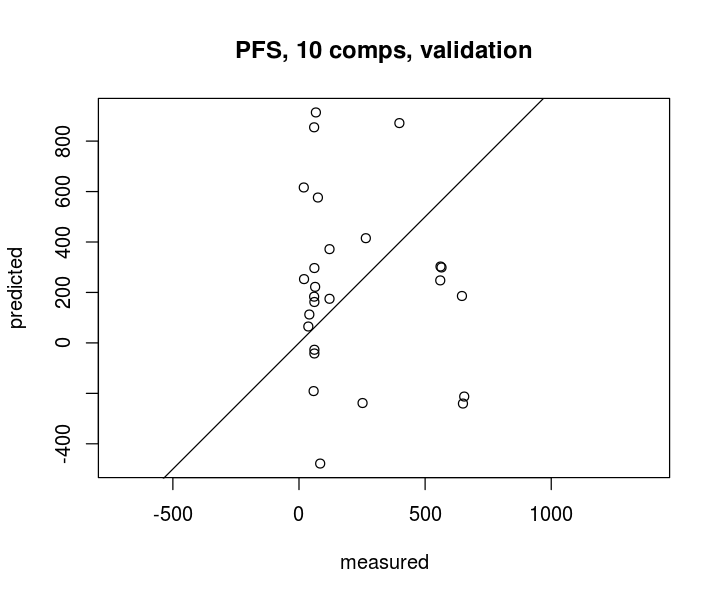

In [1325]:
plot(pls, ncomp = 10, asp = 1, line = TRUE)